In [78]:

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import skill_metrics as sm

# Load observational dataset
obs_shdr_path = "/Volumes/Thalassa/CORA_SHDR_rg/"
obs_files = sorted(glob.glob(obs_shdr_path + '*.nc'))
obs_shdr = xr.open_mfdataset(obs_files)  # Open all NetCDF files

# Compute climatological mean for observations
obs_shdr_clim = obs_shdr.groupby('time.month').mean(dim='time')

# Load CMIP6 ensemble climatology dataset
cmip6_shdr_ens_all = xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/shdr.nc")

# Extract MLD (D1) for observations and models
obs_mld = obs_shdr_clim.sel(param='a1').shdr
cmip6_mld = cmip6_shdr_ens_all.sel(param='a1').shdr  # Already climatological

def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())





In [79]:
cmip6_mld.min()

<xarray.DataArray 'shdr' ()>
array(-3.35521796)
Coordinates:
    param    <U2 'a1'

In [80]:
import xarray as xr
import numpy as np
import pprint

# Define regions correctly
regions = {
    
    "North Pacific": {"lat": slice(20, 60), "lon": (slice(120, 180), slice(180, 280))},
    "Tropical Pacific": {"lat": slice(-20, 20), "lon": (slice(120, 180), slice(180, 280))},
    "South Pacific": {"lat": slice(-45, -20), "lon": (slice(120, 180), slice(180, 280))},
    "North Atlantic": {"lat": slice(20, 60), "lon": (slice(280, 360), slice(0, 20))},
    "Tropical Atlantic": {"lat": slice(-20, 20), "lon": (slice(280, 360), slice(0, 20))},
    "South Atlantic": {"lat": slice(-45, -20), "lon": (slice(280, 360), slice(0, 20))},
    "Indian": {"lat": slice(-45, 10), "lon": (slice(45, 80),slice(80,100))},
    "Southern Ocean": {"lat": slice(-80, -45), "lon": (slice(0, 180), slice(180,360))}}


SUBPLOTS_DATA = []
rows, cols = 3, 3  # Define grid structure (adjust if needed)
i, j = 0, 0  # Initialize subplot indices

for region, bounds in regions.items():
    
    # Extract observed MLD for the region
    obs_mld_region = xr.concat([
        obs_mld.sel(lat=bounds["lat"], lon=bounds["lon"][0]),
        obs_mld.sel(lat=bounds["lat"], lon=bounds["lon"][1])
    ], dim="lon").mean(dim=["lat", "lon"])

    # Extract CMIP6 MLD for the region
    cmip6_mld_region = xr.concat([
        cmip6_mld.sel(lat=bounds["lat"], lon=bounds["lon"][0]),
        cmip6_mld.sel(lat=bounds["lat"], lon=bounds["lon"][1])
    ], dim="lon").mean(dim=["lat", "lon"])
    
    #obs_mld_region = min_max_normalize(obs_mld_region)
    #cmip6_mld_region = min_max_normalize(cmip6_mld_region)

    # Compute observed Taylor statistics
    taylor_stats_obs = sm.taylor_statistics(obs_mld_region.values, obs_mld_region.values, 'data')

    # Initialize models dictionary
    models = {}

    # Loop over models
    for m in range(len(cmip6_mld_region.model)):

        # Extract model name as a string
        model_name = cmip6_mld_region.model.isel(model=m).item()
        
        # Compute Taylor statistics
        taylor_stats = sm.taylor_statistics(cmip6_mld_region.isel(model=m).values, obs_mld_region.values, 'data')

        # Store in models dictionary
        models[f"{model_name}"] = (
            taylor_stats['sdev'][1],
            taylor_stats['crmsd'][1],
            taylor_stats['ccoef'][1]
        )

    # Define subplot title dynamically (like "1 hour lead time")
    title_label = ["(a)", "(b)", "(c)", "(d)", "(e)","(f)", "(g)", "(h)"] # Customize as needed
    title = f"{title_label[len(SUBPLOTS_DATA) % len(title_label)]} {region}"

    # Append subplot info for this region
    SUBPLOTS_DATA.append(
        {   "axis_idx": (i, j),
            "title": title,
            "y_label": True if j == 0 else False,  # Left-most column gets y-label
            "x_label": False, #True if i == rows - 1 else False,  # Bottom row gets x-label
            "observed": (
                taylor_stats_obs['sdev'][0], 
                taylor_stats_obs['crmsd'][0], 
                taylor_stats_obs['ccoef'][0]
            ),
            "modeled": models
        }
    )

    # Update subplot grid position
    j += 1
    if j >= cols:  # Move to the next row after filling all columns
        j = 0
        i += 1

# Display the final structure



In [120]:
SUBPLOTS_DATA= [{'axis_idx': (0, 0),
  'title': '(a) North Pacific',
  'y_label': True,
  'x_label': False,
  'observed': (0.6417962561010375, 0.0, 1.0),
  'modeled': {'E3SM-1-0': (0.5290332755904883,
    0.1842444317717712,
    0.9687355721981312),
   'NorESM2-LM': (0.5650551909528806, 0.16734024028641906, 0.969511172925415),
   'CMCC-CM2': (0.6579345572047829, 0.161183426979646, 0.9695452371825725),
   'MIROC6': (0.607964836722385, 0.1819415248921513, 0.9590479126780465),
   'IPSL-CM6A-LR': (0.8953953851559179,
    0.3134609420889149,
    0.9704650046027173),
   'NESM3': (0.8080119742712967, 0.2451089260380796, 0.9687118868061988),
   'FGOALS-f3-L': (0.48546413680627065,
    0.23098398063112474,
    0.9535995851496724),
   'EC-Earth3-Veg': (0.7832262097153558,
    0.2234630815820434,
    0.9702257755078825),
   'SAM0-UNICON': (0.5581379328307466,
    0.17799497495104596,
    0.9655461342917557),
   'MPI-ESM2': (0.6069263177272459, 0.16670077466308492, 0.9658900333892217),
   'EC-Earth3': (0.762159332205683, 0.20856153067832478, 0.970345924227985),
   'BCC-CSM2-MR': (0.5615598617896779, 0.1750904452080374, 0.9664007859209086),
   'ACCESS-CM2': (0.6090875495554307, 0.159781614084697, 0.9687136452139858),
   'CESM2': (0.5944866190821623, 0.16832977622673542, 0.9658007540272857),
   'GFDL-ESM4': (0.6703527938894845, 0.16334547624152299, 0.9699390163801195),
   'E3SM-1-1-ECA': (0.6871796369019576,
    0.17310597025526797,
    0.9683626183890319),
   'BCC-ESM1': (0.5902465105912577, 0.17064625537552416, 0.9650719235035415),
   'UKESM1-1': (0.7203947440902296, 0.1844893357065882, 0.9698726132275033),
   'MRI-ESM2': (0.6735216289695873, 0.16153904534955427, 0.9709802532371005),
   'CanESM5': (0.5678421871271957, 0.16437674826759613, 0.9704333075506536),
   'GISS-E2': (0.572751174377712, 0.17314638725558326, 0.9657057069968105),
   'FIO-ESM2': (0.5442051740168142, 0.18847802943494743, 0.9627794623240525)}},
 {'axis_idx': (0, 1),
  'title': '(b) Tropical Pacific',
  'y_label': False,
  'x_label': False,
  'observed': (0.059060911205874894, 0.0, 0.9999999999999999),
  'modeled': {'E3SM-1-0': (0.049655029072101974,
    0.03194437417263849,
    0.8411052008555477),
   'NorESM2-LM': (0.0536046278252138, 0.03293516270706497, 0.8333900001369154),
   'CMCC-CM2': (0.08819981273071338, 0.04304535146726388, 0.9036479539122563),
   'MIROC6': (0.03981333724944084, 0.03969877498172265, 0.7436596300234186),
   'IPSL-CM6A-LR': (0.07434986662428263,
    0.04470835931334133,
    0.7990188395519076),
   'NESM3': (0.11790139506974788, 0.0680618159201575, 0.9159739262244789),
   'FGOALS-f3-L': (0.03271086838791329,
    0.03572447574429039,
    0.8493961224688089),
   'EC-Earth3-Veg': (0.05508827681872957,
    0.03513041940519048,
    0.8127646161424777),
   'SAM0-UNICON': (0.04002287602784064,
    0.03254108399732195,
    0.8526780947437911),
   'MPI-ESM2': (0.06034577673220292, 0.018763003630215127, 0.9508428873809356),
   'EC-Earth3': (0.052741902572965, 0.03976730710375436, 0.7525655932634375),
   'BCC-CSM2-MR': (0.044964706304436254,
    0.0393150089236836,
    0.7463966215824369),
   'ACCESS-CM2': (0.05971019412903123,
    0.03886615512079769,
    0.7858868608849218),
   'CESM2': (0.0350731424903122, 0.03203501518838042, 0.8911803885304665),
   'GFDL-ESM4': (0.0644297155486022, 0.021903612271709547, 0.9407475347452153),
   'E3SM-1-1-ECA': (0.05961525598951059, 0.02463013120901, 0.913895499997774),
   'BCC-ESM1': (0.05528556074138702, 0.04229432035921118, 0.7282635384283017),
   'UKESM1-1': (0.08680456911750889, 0.053639145296917545, 0.7944658411871155),
   'MRI-ESM2': (0.05805346898524303, 0.05483010831289046, 0.5617385711776087),
   'CanESM5': (0.061187598295114685, 0.03640840449434502, 0.8172213688663094),
   'GISS-E2': (0.060229357637474404, 0.027899358541538095, 0.8907836532132146),
   'FIO-ESM2': (0.052473311637761, 0.017189150752514815, 0.9593319546450682)}},
 {'axis_idx': (0, 2),
  'title': '(c) South Pacific',
  'y_label': False,
  'x_label': False,
  'observed': (0.4322164973014129, 0.0, 1.0),
  'modeled': {'E3SM-1-0': (0.5327770760077902,
    0.1697187032882685,
    0.9594137338475608),
   'NorESM2-LM': (0.5206624634895496, 0.15717995613155733, 0.9624890425477663),
   'CMCC-CM2': (0.5034710828780659, 0.1580670014848284, 0.9542573928250719),
   'MIROC6': (0.4441372843179086, 0.12529860985684182, 0.9594776100627503),
   'IPSL-CM6A-LR': (0.5630322039333996,
    0.18938013891515643,
    0.9614712375858957),
   'NESM3': (0.7409850712802164, 0.35380243973015785, 0.9534166338527056),
   'FGOALS-f3-L': (0.45481899794883923,
    0.13581340793805918,
    0.9543840072121781),
   'EC-Earth3-Veg': (0.6233731965575726,
    0.2414062889192929,
    0.959663109474567),
   'SAM0-UNICON': (0.4967548723499908,
    0.14521011379476143,
    0.9605954123239431),
   'MPI-ESM2': (0.4969089367634888, 0.14229483496941694, 0.9626052502734539),
   'EC-Earth3': (0.6175878976313641, 0.23548258341247885, 0.9604964626210063),
   'BCC-CSM2-MR': (0.5108541034052555,
    0.15407471532561806,
    0.9602464245898404),
   'ACCESS-CM2': (0.4927615851035416, 0.14167683221230523, 0.961483140922092),
   'CESM2': (0.46367128685016945, 0.13136119675805152, 0.9594165608185654),
   'GFDL-ESM4': (0.5398075170207854, 0.1762676508557691, 0.9582226503940825),
   'E3SM-1-1-ECA': (0.5921553934428533,
    0.2147533346051265,
    0.9598761467725277),
   'BCC-ESM1': (0.5463555472552765, 0.17856597953777242, 0.9600707707293255),
   'UKESM1-1': (0.42643807317146515, 0.1201512057738876, 0.9609282104408167),
   'MRI-ESM2': (0.44288780411826856, 0.12259655829287992, 0.9610391464246503),
   'CanESM5': (0.4249301142030188, 0.11961131152895854, 0.9611955941964649),
   'GISS-E2': (0.5415567787984795, 0.1752265328456736, 0.9599498894430368),
   'FIO-ESM2': (0.4328211813755558, 0.12307127148769724, 0.9595178984927637)}},
 {'axis_idx': (1, 0),
  'title': '(d) North Atlantic',
  'y_label': True,
  'x_label': False,
  'observed': (0.6012425080660831, 0.0, 0.9999999999999998),
  'modeled': {'E3SM-1-0': (0.5084803741128844,
    0.17213111278712265,
    0.9656150964405533),
   'NorESM2-LM': (0.5117391582828503, 0.15535637100450142, 0.9737961725814568),
   'CMCC-CM2': (0.553245371468825, 0.15136862300778822, 0.96902196470428),
   'MIROC6': (0.549945440322247, 0.15288117348788852, 0.9686356752966512),
   'IPSL-CM6A-LR': (0.7864304182611384,
    0.24289674269208064,
    0.973876463479892),
   'NESM3': (0.784461592745762, 0.2460613641835475, 0.9714016036642726),
   'FGOALS-f3-L': (0.4271403910883758,
    0.22356171299158945,
    0.9617072689671436),
   'EC-Earth3-Veg': (0.6547382769681841,
    0.1621501348774813,
    0.9702394474417245),
   'SAM0-UNICON': (0.5294438459495135,
    0.15735858863807298,
    0.9692032825753734),
   'MPI-ESM2': (0.5928159782665724, 0.1466338938797015, 0.969936982047729),
   'EC-Earth3': (0.6226482190210535, 0.1500072277210081, 0.9705580027620412),
   'BCC-CSM2-MR': (0.545898924976312, 0.1483947359450771, 0.971119642539452),
   'ACCESS-CM2': (0.5759468645617885, 0.13971231676291376, 0.9727396065163292),
   'CESM2': (0.5392017380982418, 0.1566759502361757, 0.9680770041403138),
   'GFDL-ESM4': (0.6320388633206321, 0.1490210979086422, 0.9720284351860169),
   'E3SM-1-1-ECA': (0.6685436751540722,
    0.17935471661852018,
    0.9656198600744779),
   'BCC-ESM1': (0.5947764837388096, 0.14143422378079867, 0.9720895464285916),
   'UKESM1-1': (0.6798608538665164, 0.17204290343646703, 0.9713550188309285),
   'MRI-ESM2': (0.5717557216428125, 0.14351747561343536, 0.9713061807218516),
   'CanESM5': (0.5205062733092479, 0.1546314320163108, 0.9722119946785059),
   'GISS-E2': (0.501461289694725, 0.16765570897318277, 0.9698969243233148),
   'FIO-ESM2': (0.5048268305264533, 0.16750785445856134, 0.9690915073800774)}},
 {'axis_idx': (1, 1),
  'title': '(e) Tropical Atlantic',
  'y_label': False,
  'x_label': False,
  'observed': (0.0989690093445971, 0.0, 1.0),
  'modeled': {'E3SM-1-0': (0.06747005429075502,
    0.0622213663258719,
    0.7843999836603854),
   'NorESM2-LM': (0.11076265112327742,
    0.07275940624792927,
    0.7648782903330092),
   'CMCC-CM2': (0.15329713394520192, 0.08653656467198363, 0.8504768013763709),
   'MIROC6': (0.20399902778871962, 0.1206170660724377, 0.9128963663539933),
   'IPSL-CM6A-LR': (0.19902921633689746,
    0.1168012187884449,
    0.9078452003222752),
   'NESM3': (0.14244612894706893, 0.08747616671150592, 0.7956475718773156),
   'FGOALS-f3-L': (0.09970648313837832,
    0.058876513374581906,
    0.8243842728783447),
   'EC-Earth3-Veg': (0.19304842293737257,
    0.11335000728242108,
    0.8953907778990926),
   'SAM0-UNICON': (0.08636777277767341,
    0.06810468294371416,
    0.7379739913241588),
   'MPI-ESM2': (0.12676215130488644, 0.05679501190084286, 0.9022274983580733),
   'EC-Earth3': (0.19705033225420016, 0.11581419880772732, 0.9027533887536515),
   'BCC-CSM2-MR': (0.11816219726714898,
    0.06138099721093007,
    0.8546633588153957),
   'ACCESS-CM2': (0.09522075633755957,
    0.04352802486359688,
    0.9002197198139252),
   'CESM2': (0.1095435058753247, 0.04586384260577336, 0.9081451735924186),
   'GFDL-ESM4': (0.16530424674140964, 0.09769624662155314, 0.8427813674565603),
   'E3SM-1-1-ECA': (0.12722232863433341,
    0.07869399519695411,
    0.785780884457834),
   'BCC-ESM1': (0.11708807645011582, 0.05254123248129509, 0.895052578889729),
   'UKESM1-1': (0.0869585969346345, 0.04104195360587686, 0.9105185307522107),
   'MRI-ESM2': (0.09362440600605862, 0.03647920512344509, 0.9297334552529521),
   'CanESM5': (0.12868161688085894, 0.059905647836574885, 0.8937674506169684),
   'GISS-E2': (0.10494161545943248, 0.04073291781517057, 0.9218417284965507),
   'FIO-ESM2': (0.0966408345727376,
    0.046531504653518796,
    0.8870943412337656)}},
 {'axis_idx': (1, 2),
  'title': '(f) South Atlantic',
  'y_label': False,
  'x_label': False,
  'observed': (0.42158767114436857, 0.0, 1.0),
  'modeled': {'E3SM-1-0': (0.4478669245528121,
    0.13016466688310002,
    0.956962565491448),
   'NorESM2-LM': (0.4472816390551245, 0.12689857473496866, 0.9590518181418213),
   'CMCC-CM2': (0.4551686641972137, 0.13067662826297377, 0.9584438808000435),
   'MIROC6': (0.3905048148457472, 0.1326667767585712, 0.9494802707322754),
   'IPSL-CM6A-LR': (0.47530014421489264,
    0.1392434832541572,
    0.9588190892661008),
   'NESM3': (0.6838416385018568, 0.3023679912577145, 0.9607191791663737),
   'FGOALS-f3-L': (0.43914284232463163,
    0.14216852395792806,
    0.946246069703598),
   'EC-Earth3-Veg': (0.5641902769703754,
    0.20245048927395765,
    0.9565898558202978),
   'SAM0-UNICON': (0.48304359037640504,
    0.14531245444232455,
    0.9574287105555785),
   'MPI-ESM2': (0.4530451388468364, 0.13235849285615942, 0.9567294496447823),
   'EC-Earth3': (0.5484800966268835, 0.18898775433576004, 0.957586653750495),
   'BCC-CSM2-MR': (0.5007531290615679,
    0.15478660641693143,
    0.9580985954189586),
   'ACCESS-CM2': (0.4537483918763796, 0.13517809346890167, 0.95494176658019),
   'CESM2': (0.4312168396682868, 0.12849933718772616, 0.954841180284381),
   'GFDL-ESM4': (0.5049505142128786, 0.15175634901221427, 0.9622309352196631),
   'E3SM-1-1-ECA': (0.5654756542175596,
    0.2038323659192498,
    0.9562833584360441),
   'BCC-ESM1': (0.563160508963504, 0.20058473329346022, 0.9574778095340928),
   'UKESM1-1': (0.39523527380542134, 0.12298797663099965, 0.9566947356568153),
   'MRI-ESM2': (0.4097627798940282, 0.12299853102920086, 0.9566172811537522),
   'CanESM5': (0.4102736716398754, 0.1241049876036353, 0.9558467763896937),
   'GISS-E2': (0.49653994512407434, 0.15123015343378887, 0.9587916351363674),
   'FIO-ESM2': (0.4144324211499318, 0.12580318837299478, 0.9548555380524063)}},
 {'axis_idx': (2, 0),
  'title': '(g) Indian',
  'y_label': True,
  'x_label': False,
  'observed': (0.3402219674327887, 0.0, 1.0),
  'modeled': {'E3SM-1-0': (0.4069323096877007,
    0.12726180569432902,
    0.9575820673626774),
   'NorESM2-LM': (0.38232443757382584,
    0.11194714118919234,
    0.9586410525769384),
   'CMCC-CM2': (0.37994001277275957, 0.12581347610716923, 0.9448743872685555),
   'MIROC6': (0.3361450812217081, 0.11651717588874005, 0.9407171912228905),
   'IPSL-CM6A-LR': (0.39491957192397353,
    0.12562140275009573,
    0.9524081608026185),
   'NESM3': (0.5122787748951888, 0.2335131017277887, 0.9284954981745998),
   'FGOALS-f3-L': (0.3291398775645324,
    0.10008795841260998,
    0.9558191989182799),
   'EC-Earth3-Veg': (0.3993981063029615,
    0.12288361988568208,
    0.9573218045817273),
   'SAM0-UNICON': (0.307455699049944, 0.10289266016511085, 0.9545268560917001),
   'MPI-ESM2': (0.40747418047749495, 0.1354175539188471, 0.9501735281230276),
   'EC-Earth3': (0.4031315807770419, 0.12287194347713312, 0.9593891639660147),
   'BCC-CSM2-MR': (0.38697859320464545,
    0.11767287282598109,
    0.9557160666993791),
   'ACCESS-CM2': (0.37590993706125275,
    0.11125858767864373,
    0.9565853567930857),
   'CESM2': (0.37920224770056943, 0.1120167314872316, 0.9572589914988298),
   'GFDL-ESM4': (0.3665443821504144, 0.10780723726982361, 0.9561789674191542),
   'E3SM-1-1-ECA': (0.3999458814856366,
    0.12281944996121423,
    0.9576775201535183),
   'BCC-ESM1': (0.3838811105931962, 0.11343617250141405, 0.9580350585659633),
   'UKESM1-1': (0.3565368429927499, 0.10352829062752092, 0.9569176082884311),
   'MRI-ESM2': (0.3706699208023819, 0.1085472571444843, 0.9569604912812617),
   'CanESM5': (0.39476318613118294, 0.1268262445912618, 0.9511933806432898),
   'GISS-E2': (0.3872976941352974, 0.11543677434367619, 0.9578441136373138),
   'FIO-ESM2': (0.31457215849249603, 0.1001388164038006, 0.9562255267434902)}},
 {'axis_idx': (2, 1),
  'title': '(h) Southern Ocean',
  'y_label': False,
  'x_label': False,
  'observed': (0.13753659484876776, 0.0, 0.9999999999999998),
  'modeled': {'E3SM-1-0': (0.1853301742581534,
    0.06761018730912664,
    0.9551404510099262),
   'NorESM2-LM': (0.14306463979317524,
    0.044435301176135956,
    0.9506028887643106),
   'CMCC-CM2': (0.14709798313083394, 0.04685449361303491, 0.9480033998679542),
   'MIROC6': (0.18120093019180963, 0.06647962542236474, 0.9495828841131904),
   'IPSL-CM6A-LR': (0.2897608061565265,
    0.16329444332596388,
    0.9561778319497515),
   'NESM3': (0.19609079462057968, 0.08887514483494834, 0.9171254470803325),
   'FGOALS-f3-L': (0.25640702027414725,
    0.1346642999521069,
    0.9432262005735192),
   'EC-Earth3-Veg': (0.2871404684173886,
    0.16234396538689583,
    0.9496833323235038),
   'SAM0-UNICON': (0.20375290639085908,
    0.08382971470433831,
    0.9528463084359388),
   'MPI-ESM2': (0.1845442264101508, 0.07547331731052583, 0.9313182319070774),
   'EC-Earth3': (0.2645881377276889, 0.14043951792855414, 0.9507954194092559),
   'BCC-CSM2-MR': (0.15052554629002476,
    0.04869992935697317,
    0.9467952804021884),
   'ACCESS-CM2': (0.2270320206962543, 0.1033698256028461, 0.9571517772384388),
   'CESM2': (0.18118923873088466, 0.06523099042388218, 0.9528588570453318),
   'GFDL-ESM4': (0.18045640893186615, 0.06877026153513682, 0.9418349540374978),
   'E3SM-1-1-ECA': (0.21834137872812498,
    0.0960727317463957,
    0.9550355809958512),
   'BCC-ESM1': (0.17192687290684733, 0.05980115984633161, 0.9493896739636447),
   'UKESM1-1': (0.14143782972173127, 0.043286198619977095, 0.9522313508866664),
   'MRI-ESM2': (0.18110391209807583, 0.06390907289853293, 0.9561140595906078),
   'CanESM5': (0.12019181874023249, 0.043125126522770424, 0.9528474792360901),
   'GISS-E2': (0.1639202976345889, 0.055864390539402696, 0.9462247482235517),
   'FIO-ESM2': (0.18437038841988723, 0.0671251267793448, 0.9544047633091692)}}]

# Create labels

import matplotlib.pyplot as plt

model_names = ['Obs'] + list(cmip6_mld_region.model.values)

# Define marker styles (at least 22 unique ones)
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', '*', 'p', 'X', 'H', 'h', 
                 '+', 'x', '|', '_', '1', '2', '3', '4', 'P', '.','8']

# Define a list of colors for diversity
colors = plt.cm.get_cmap("tab20", 23)  # Using a colormap to generate 22 colors

MARKERS = {}
for i, model in enumerate(model_names):
    MARKERS[model] = {
        "marker": marker_styles[i % len(marker_styles)],  # Cycle through available markers
        "color_edge": "#000000",  # Edge color (black for contrast)
        "color_face": plt.cm.tab20(i / len(model_names)),  # Unique face color per model
        "markersize": 9 if i > 0 else 12  # Larger size for observation
    }


FONT_FAMILY = 'Times New Roman'
FONT_SIZE = 9

# specify some styles for the correlation component
COLS_COR = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'title': '#000000'
}

# specify some styles for the standard deviation
COLS_STD = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'ticks': '#DDDDDD',
    'title': '#000000'
}

# specify some styles for the root mean square deviation
STYLES_RMS = {
    'color': '#AAAADD',
    'linestyle': '--'
}


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

def calculate_rmse_ticks(max_rmse):
    if max_rmse > 40:
        step = 20
    elif max_rmse > 20:
        step = 10
    elif max_rmse > 5:
        step = 2
    else:
        step = 1
    return np.arange(0, max_rmse, step)[1::]

LEGEND_SUBPLOT = (2, 2)

# Create figure and subplots grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)

for subplot_data in SUBPLOTS_DATA:
    
    # Get subplot object and ensure it will be a square
    ax = axs[subplot_data["axis_idx"][0]][subplot_data["axis_idx"][1]]
    ax.set(adjustable='box', aspect='equal')

    # Extract observed Taylor statistics
    stdev_obs, crmsd_obs, ccoef_obs = subplot_data["observed"] 

    max_stdev = max([stdev_obs] + [m[0] for m in subplot_data["modeled"].values()])
    max_rmse = max([crmsd_obs] + [m[1] for m in subplot_data["modeled"].values()])
    rmse_ticks = calculate_rmse_ticks(max_rmse)
    stdev_ticks = calculate_rmse_ticks(max_stdev)

    # Plot observed point on Taylor Diagram
    sm.taylor_diagram(
        ax,
        np.asarray((stdev_obs, stdev_obs)), 
        np.asarray((crmsd_obs, crmsd_obs)), 
        np.asarray((ccoef_obs, ccoef_obs)),
        markercolors={
            "face": MARKERS["Obs"]["color_edge"],
            "edge": MARKERS["Obs"]["color_face"]
        },
        markersize=MARKERS["Obs"]["markersize"],
        markersymbol=MARKERS["Obs"]["marker"],
        styleOBS=':',
        colOBS=MARKERS["Obs"]["color_edge"],
        alpha=1.0,
        titleSTD='off',
        titleRMS='off',
        titleCOR='off',
        showlabelsRMS='on',
        #tickRMS=rmse_ticks,
        tickRMS=[0.05, 0.1, 0.2, 0.4],
        #tickRMSlabels = [f"{x:.1f}" for x in [0.1, 0.5]],
        colRMS=STYLES_RMS['color'],
        tickRMSangle=115,
        #tickSTD=stdev_ticks,
        styleRMS=STYLES_RMS['linestyle'],
        colscor=COLS_COR,
        colsstd=COLS_STD,
        styleCOR='-',
        styleSTD='-',
        colframe='#DDDDDD',
        labelweight='normal',
        titlecorshape='linear',
        axisMax=max_stdev * 1.1  # Set the maximum limit for the radial contours
        )


    # Label the observed point
    #ax.text(stdev_obs, -0.2, "Obs", verticalalignment="top",
     #       horizontalalignment="center", 
     #       fontsize=FONT_SIZE + 1, fontweight="bold")
    
    #ax.set_xticks([stdev_obs])
    #ax.set_xticklabels(["Obs"], fontsize=FONT_SIZE + 1, fontweight="bold")#verticalalignment="top",
            #horizontalalignment="center", 
            #fontsize=FONT_SIZE + 1, fontweight="bold")

    # Loop through modeled values and overlay markers
    for model_id, (stdev, crmsd, ccoef) in subplot_data["modeled"].items():
        marker = MARKERS[model_id]  # Get model-specific marker

        sm.taylor_diagram(
            ax,
            np.asarray((stdev, stdev)),
            np.asarray((crmsd, crmsd)),
            np.asarray((ccoef, ccoef)),
            markersymbol=marker["marker"],
            markercolors={
                "face": marker["color_face"],
                "edge": marker["color_edge"]
            },
            markersize=marker["markersize"],
            alpha=1.0,
            overlay='on',
            styleCOR='-',
            styleSTD='-',
        )

    # Set subplot title
    ax.set_title(subplot_data["title"], loc="left", y=1.1)
    ax.set_yticks(stdev_ticks)
    

    # Set y-labels (only for leftmost subplots)
    if subplot_data["y_label"]:
        ax.set_ylabel("Standard Deviation", fontfamily=FONT_FAMILY,
                      fontsize=FONT_SIZE + 2)

    # Set x-labels or hide tick labels
    #if subplot_data["x_label"]:
    #    ax.set_xlabel("Standard Deviation", fontfamily=FONT_FAMILY,
    #                  fontsize=FONT_SIZE + 2)
    #else:
        #ax.set_xticklabels(ax.get_xticklabels(), color=ax.get_facecolor())
    
    ax.set_xticks([stdev_obs])
    ax.set_xticklabels(["Obs"], fontsize=FONT_SIZE + 1, fontweight="bold")
    
    #print(stdev_ticks)
# Create a legend in the last subplot
ax = axs[LEGEND_SUBPLOT[0]][LEGEND_SUBPLOT[1]]
ax.axis('off')

# Build legend handles    
legend_handles = []
legend_handles.append(mlines.Line2D([], [],
                                    color=STYLES_RMS['color'],
                                    linestyle=STYLES_RMS['linestyle'],
                                    label="RMSE"))

for marker_label, marker_desc in MARKERS.items():
    marker = mlines.Line2D([], [], 
                           marker=marker_desc["marker"],
                           markersize=marker_desc["markersize"],
                           markerfacecolor=marker_desc["color_face"],
                           markeredgecolor=marker_desc["color_edge"],
                           linestyle='None',
                           label=marker_label)
    legend_handles.append(marker)

# Create the legend
ax.legend(handles=legend_handles, loc="center", ncol=2, bbox_to_anchor=(0.5, 0.5))    

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()



/Users/ignasi/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


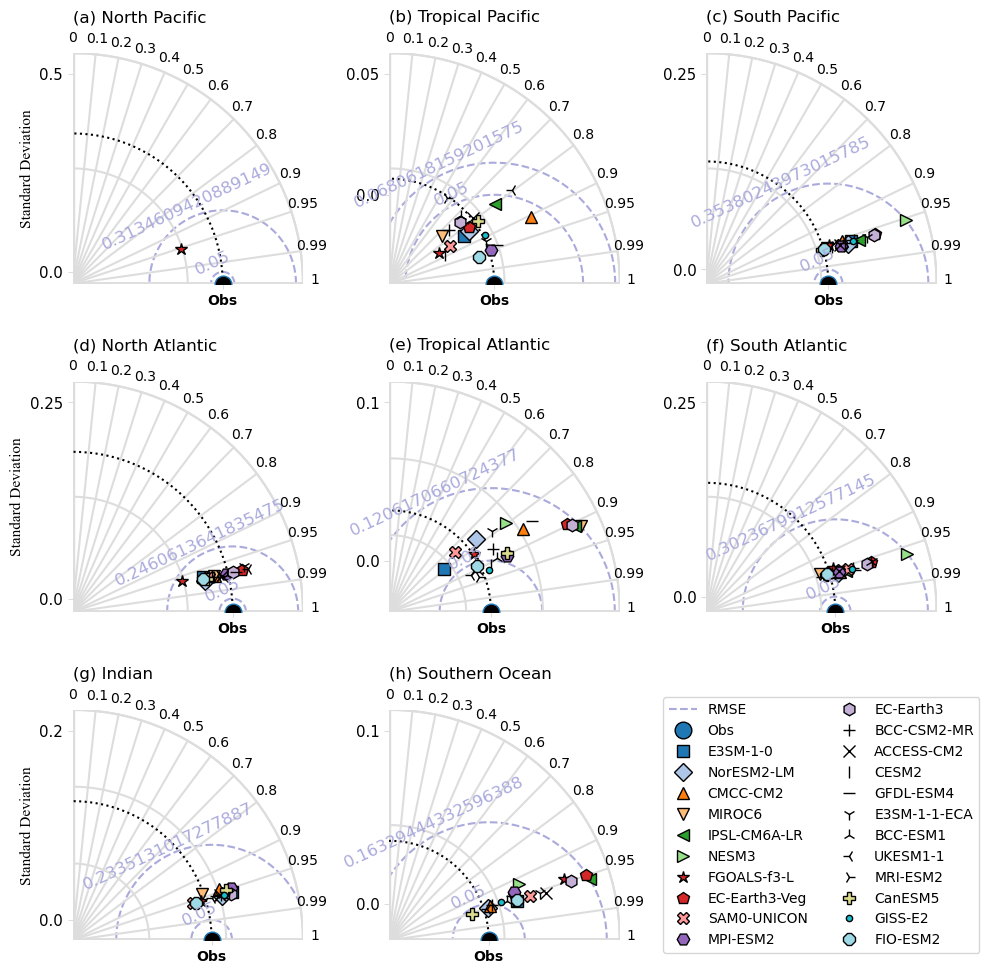

In [126]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

# Function to calculate RMSE ticks
def calculate_rmse_ticks(max_rmse):
    if max_rmse > 40:
        step = 20
    elif max_rmse > 20:
        step = 10
    elif max_rmse > 5:
        step = 2
    else:
        step = 1
    ticks = np.arange(0, max_rmse, step)[1::]
    return ticks if len(ticks) > 1 else np.array([0.05, max_rmse])  # Ensure at least two ticks

LEGEND_SUBPLOT = (2, 2)

# Create figure and subplots grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)

for subplot_data in SUBPLOTS_DATA:
    
    ax = axs[subplot_data["axis_idx"][0]][subplot_data["axis_idx"][1]]
    ax.set(adjustable='box', aspect='equal')

    stdev_obs, crmsd_obs, ccoef_obs = subplot_data["observed"]

    max_stdev = max([stdev_obs] + [m[0] for m in subplot_data["modeled"].values()])
    max_rmse = max([crmsd_obs] + [m[1] for m in subplot_data["modeled"].values()])
    rmse_ticks = calculate_rmse_ticks(max_rmse)
    stdev_ticks = calculate_rmse_ticks(max_stdev)

    # Plot observed point
    sm.taylor_diagram(
        ax,
        np.asarray((stdev_obs, stdev_obs)), 
        np.asarray((crmsd_obs, crmsd_obs)), 
        np.asarray((ccoef_obs, ccoef_obs)),
        markercolors={
            "face": MARKERS["Obs"]["color_edge"],
            "edge": MARKERS["Obs"]["color_face"]
        },
        markersize=MARKERS["Obs"]["markersize"],
        markersymbol=MARKERS["Obs"]["marker"],
        styleOBS=':',
        colOBS=MARKERS["Obs"]["color_edge"],
        alpha=1.0,
        titleSTD='off',
        titleRMS='off',
        titleCOR='off',
        showlabelsRMS='on',
        tickRMS=rmse_ticks,
        colRMS=STYLES_RMS['color'],
        tickRMSangle=115,
        styleRMS=STYLES_RMS['linestyle'],
        colscor=COLS_COR,
        colsstd=COLS_STD,
        styleCOR='-',
        styleSTD='-',
        colframe='#DDDDDD',
        labelweight='normal',
        titlecorshape='linear',
        axisMax=max_stdev * 1.1
    )

    # Plot modeled values with overlay=True only for first model, then set it to False
    first_model = True
    for model_id, (stdev, crmsd, ccoef) in subplot_data["modeled"].items():
        marker = MARKERS[model_id]
        
        sm.taylor_diagram(
            ax,
            np.asarray((stdev, stdev)),
            np.asarray((crmsd, crmsd)),
            np.asarray((ccoef, ccoef)),
            markersymbol=marker["marker"],
            markercolors={
                "face": marker["color_face"],
                "edge": marker["color_edge"]
            },
            markersize=marker["markersize"],
            alpha=1.0,
            overlay=True,  # Keep overlay enabled for all models
            styleCOR='-',
            styleSTD='-',
        )

    ax.set_title(subplot_data["title"], loc="left", y=1.1)
    ax.set_yticks(stdev_ticks)

    if subplot_data["y_label"]:
        ax.set_ylabel("Standard Deviation", fontfamily=FONT_FAMILY, fontsize=FONT_SIZE + 2)
    
    ax.set_xticks([stdev_obs])
    ax.set_xticklabels(["Obs"], fontsize=FONT_SIZE + 1, fontweight="bold")

# Create a legend in the last subplot
ax = axs[LEGEND_SUBPLOT[0]][LEGEND_SUBPLOT[1]]
ax.axis('off')

legend_handles = [
    mlines.Line2D([], [],
                  color=STYLES_RMS['color'],
                  linestyle=STYLES_RMS['linestyle'],
                  label="RMSE")
]

for marker_label, marker_desc in MARKERS.items():
    legend_handles.append(mlines.Line2D([], [], 
                                        marker=marker_desc["marker"],
                                        markersize=marker_desc["markersize"],
                                        markerfacecolor=marker_desc["color_face"],
                                        markeredgecolor=marker_desc["color_edge"],
                                        linestyle='None',
                                        label=marker_label))

ax.legend(handles=legend_handles, loc="center", ncol=2, bbox_to_anchor=(0.5, 0.5))

plt.tight_layout()
plt.show()

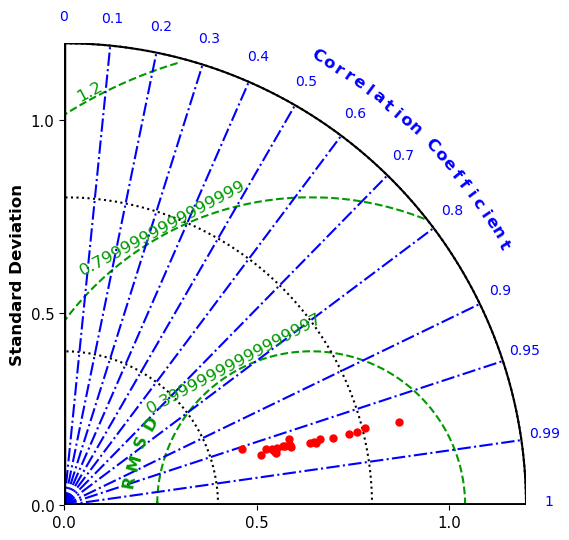

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import skill_metrics as sm

# Define observed and modeled data
observed = (0.6418, 0.0, 1.0)
modeled= {'E3SM-1-0': (0.5290332755904883,
    0.1842444317717712,
    0.9687355721981312),
   'NorESM2-LM': (0.5650551909528806, 0.16734024028641906, 0.969511172925415),
   'CMCC-CM2': (0.6579345572047829, 0.161183426979646, 0.9695452371825725),
   'MIROC6': (0.607964836722385, 0.1819415248921513, 0.9590479126780465),
   'IPSL-CM6A-LR': (0.8953953851559179,
    0.3134609420889149,
    0.9704650046027173),
   'NESM3': (0.8080119742712967, 0.2451089260380796, 0.9687118868061988),
   'FGOALS-f3-L': (0.48546413680627065,
    0.23098398063112474,
    0.9535995851496724),
   'EC-Earth3-Veg': (0.7832262097153558,
    0.2234630815820434,
    0.9702257755078825),
   'SAM0-UNICON': (0.5581379328307466,
    0.17799497495104596,
    0.9655461342917557),
   'MPI-ESM2': (0.6069263177272459, 0.16670077466308492, 0.9658900333892217),
   'EC-Earth3': (0.762159332205683, 0.20856153067832478, 0.970345924227985),
   'BCC-CSM2-MR': (0.5615598617896779, 0.1750904452080374, 0.9664007859209086),
   'ACCESS-CM2': (0.6090875495554307, 0.159781614084697, 0.9687136452139858),
   'CESM2': (0.5944866190821623, 0.16832977622673542, 0.9658007540272857),
   'GFDL-ESM4': (0.6703527938894845, 0.16334547624152299, 0.9699390163801195),
   'E3SM-1-1-ECA': (0.6871796369019576,
    0.17310597025526797,
    0.9683626183890319),
   'BCC-ESM1': (0.5902465105912577, 0.17064625537552416, 0.9650719235035415),
   'UKESM1-1': (0.7203947440902296, 0.1844893357065882, 0.9698726132275033),
   'MRI-ESM2': (0.6735216289695873, 0.16153904534955427, 0.9709802532371005),
   'CanESM5': (0.5678421871271957, 0.16437674826759613, 0.9704333075506536),
   'GISS-E2': (0.572751174377712, 0.17314638725558326, 0.9657057069968105),
   'FIO-ESM2': (0.5442051740168142, 0.18847802943494743, 0.9627794623240525)}

# Convert to NumPy arrays
stdev_obs, crmsd_obs, ccoef_obs = np.array(observed)
stdev = np.array([m[0] for m in modeled.values()])
crmsd = np.array([m[1] for m in modeled.values()])
ccoef = np.array([m[2] for m in modeled.values()])

# Create Taylor Diagram
fig, ax = plt.subplots(figsize=(6, 6))

sm.taylor_diagram(
    ax,
    np.append(stdev_obs, stdev),
    np.append(crmsd_obs, crmsd),
    np.append(ccoef_obs, ccoef),
    overlay='off',
    axisMax=1.2
)

plt.show()



In [129]:
print(stdev_obs)

0.6418


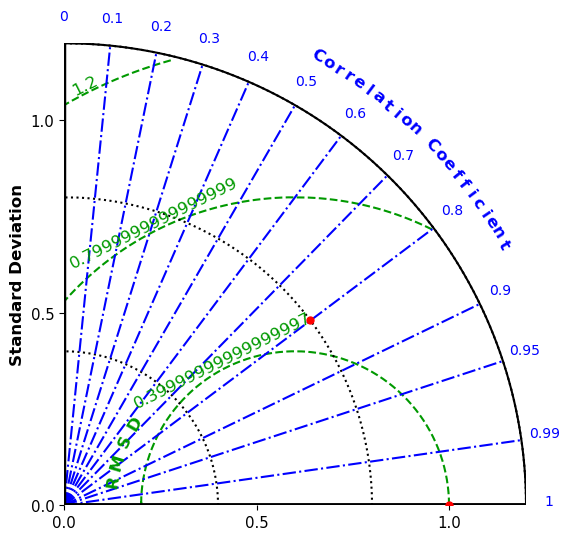

In [118]:
import matplotlib.pyplot as plt
import skill_metrics as sm
import numpy as np

fig, ax = plt.subplots(figsize=(6, 6))

# Simple data to plot
stdev = np.array([0.6, 0.8, 1.0])
crmsd = np.array([0.2, 0.3, 0.0])
ccoef = np.array([0.9, 0.8, 1.0])

sm.taylor_diagram(
    ax,
    stdev,
    crmsd,
    ccoef,
    overlay='off',  # Start fresh
    axisMax=1.2
)

plt.show()



In [46]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

def calculate_rmse_ticks(max_rmse):
    if max_rmse > 40:
        step = 20
    elif max_rmse > 20:
        step = 10
    elif max_rmse > 5:
        step = 2
    else:
        step = 1
    return np.arange(0, max_rmse, step)[1::]

LEGEND_SUBPLOT = (2,2)

# Create figure and subplots grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for subplot_data in SUBPLOTS_DATA:
    
    # Get subplot object and ensure it will be a square
    ax = axs[subplot_data["axis_idx"][0]][subplot_data["axis_idx"][1]]
    ax.set(adjustable='box', aspect='equal')

    # Extract observed Taylor statistics
    stdev_obs, crmsd_obs, ccoef_obs = subplot_data["observed"] 

    max_stdev = max([stdev_obs] + [m[0] for m in subplot_data["modeled"].values()])
    max_rmse = max([crmsd_obs] + [m[1] for m in subplot_data["modeled"].values()])
    rmse_ticks = calculate_rmse_ticks(max_rmse)
    stdev_ticks = calculate_rmse_ticks(max_stdev)

    # Plot observed point on Taylor Diagram
    sm.taylor_diagram(
        ax,
        np.asarray((stdev_obs, stdev_obs)), 
        np.asarray((crmsd_obs, crmsd_obs)), 
        np.asarray((ccoef_obs, ccoef_obs)),
        markercolors={
            "face": MARKERS["Obs"]["color_edge"],
            "edge": MARKERS["Obs"]["color_face"]
        },
        markersize=MARKERS["Obs"]["markersize"],
        markersymbol=MARKERS["Obs"]["marker"],
        styleOBS=':',
        colOBS=MARKERS["Obs"]["color_edge"],
        alpha=1.0,
        titleSTD='off',
        titleRMS='off',
        showlabelsRMS='on',
        #tickRMS=rmse_ticks,
        colRMS=STYLES_RMS['color'],
        tickRMSangle=115,
        #tickSTD=stdev_ticks,
        styleRMS=STYLES_RMS['linestyle'],
        colscor=COLS_COR,
        colsstd=COLS_STD,
        styleCOR='-',
        styleSTD='-',
        colframe='#DDDDDD',
        labelweight='normal',
        titlecorshape='linear',
        axisMax=max_stdev * 1.1  # Set the maximum limit for the radial contours
        )


    # Label the observed point
    ax.text(stdev_obs, -0.2, "Obs", verticalalignment="top",
            horizontalalignment="center", 
            fontsize=FONT_SIZE + 1, fontweight="bold")

    # Loop through modeled values and overlay markers
    for model_id, (stdev, crmsd, ccoef) in subplot_data["modeled"].items():
        marker = MARKERS[model_id]  # Get model-specific marker

        sm.taylor_diagram(
            ax,
            np.asarray((stdev, stdev)),
            np.asarray((crmsd, crmsd)),
            np.asarray((ccoef, ccoef)),
            markersymbol=marker["marker"],
            markercolors={
                "face": marker["color_face"],
                "edge": marker["color_edge"]
            },
            markersize=marker["markersize"],
            alpha=1.0,
            overlay='on',
            styleCOR='-',
            styleSTD='-',
        )

    # Set subplot title
    ax.set_title(subplot_data["title"], loc="left", y=1.1)
    ax.set_yticks(stdev_ticks)

    # Set y-labels (only for leftmost subplots)
    if subplot_data["y_label"]:
        ax.set_ylabel("Standard Deviation", fontfamily=FONT_FAMILY,
                      fontsize=FONT_SIZE + 2)

    # Set x-labels or hide tick labels
    if subplot_data["x_label"]:
        ax.set_xlabel("Standard Deviation", fontfamily=FONT_FAMILY,
                      fontsize=FONT_SIZE + 2)
    else:
        ax.set_xticklabels(ax.get_xticklabels(), color=ax.get_facecolor())
    ax.set_yticks(stdev_ticks)
    ax.set_yticklabels(stdev_ticks)
    print(stdev_ticks)
    
    ax.set_xlim(0, max_stdev * 1.1)
    ax.set_ylim(0, max_stdev * 1.1)
    
# Create a legend in the last subplot
ax = axs[LEGEND_SUBPLOT[0]][LEGEND_SUBPLOT[1]]
ax.axis('off')

# Build legend handles    
legend_handles = []
legend_handles.append(mlines.Line2D([], [],
                                    color=STYLES_RMS['color'],
                                    linestyle=STYLES_RMS['linestyle'],
                                    label="RMSE"))

for marker_label, marker_desc in MARKERS.items():
    marker = mlines.Line2D([], [], 
                           marker=marker_desc["marker"],
                           markersize=marker_desc["markersize"],
                           markerfacecolor=marker_desc["color_face"],
                           markeredgecolor=marker_desc["color_edge"],
                           linestyle='None',
                           label=marker_label)
    legend_handles.append(marker)

# Create the legend
ax.legend(handles=legend_handles, loc="center", ncol=2, bbox_to_anchor=(0.5, 0.5))    

# Adjust layout to avoid overlapping
#plt.tight_layout()

# Show the plot
plt.show()



[]
[]
[]
[]
[]
[]
[]
[]


ValueError: Image size of 976x359635 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x1000 with 9 Axes>

In [27]:

max_stdev*1.1
        

0.0006869814406034058

In [85]:
stdev_obs

0.6417962561010375

['Non-Dimensional Observation',
 array(['E3SM-1-0', 'NorESM2-LM', 'CMCC-CM2', 'MIROC6', 'IPSL-CM6A-LR',
        'NESM3', 'FGOALS-f3-L', 'EC-Earth3-Veg', 'SAM0-UNICON', 'MPI-ESM2',
        'EC-Earth3', 'BCC-CSM2-MR', 'ACCESS-CM2', 'CESM2', 'GFDL-ESM4',
        'E3SM-1-1-ECA', 'BCC-ESM1', 'UKESM1-1', 'MRI-ESM2', 'CanESM5',
        'GISS-E2', 'FIO-ESM2'], dtype='<U13')]

In [14]:

taylor_stats1 = sm.taylor_statistics(cmip6_mld_region.isel(model=1).values,obs_mld_region.values,'data')

In [15]:
taylor_stats1 

{'ccoef': array([1.        , 0.79116794]),
 'crmsd': [0.0, np.float64(40.42803316994444)],
 'sdev': [np.float64(36.54614921491551), np.float64(62.60141527389671)]}

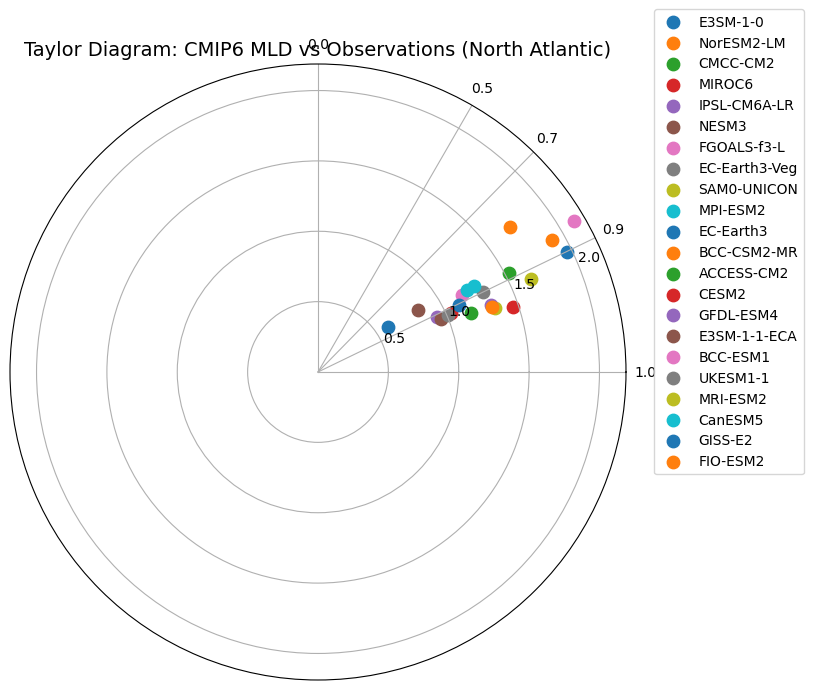

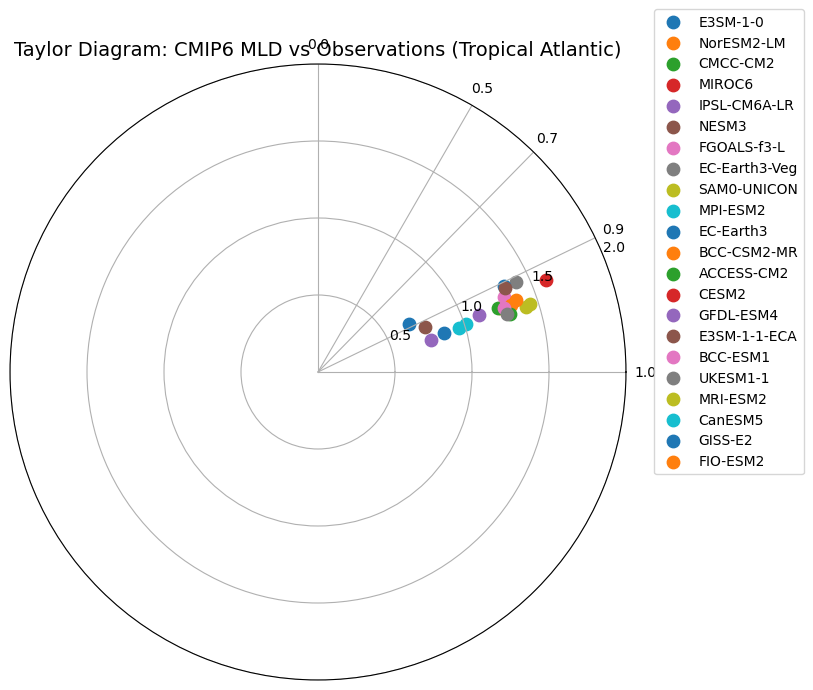

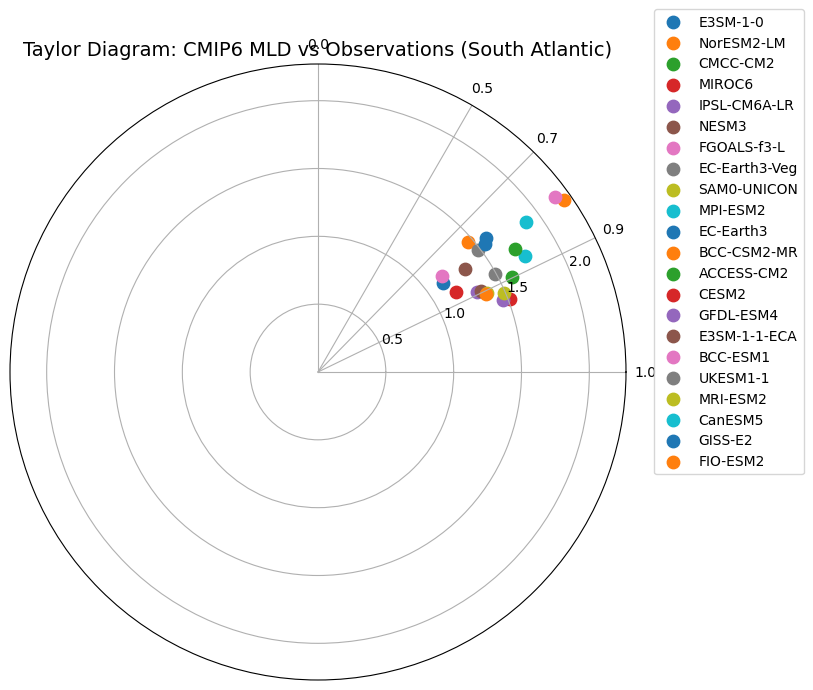

In [ ]:
# Define regional boundaries with longitude adjustments (0–365 range)
regions = {
    "North Atlantic": {"lat": slice(20, 60), "lon": (slice(280, 360), slice(0, 20))}}

#    "Tropical Atlantic": {"lat": slice(-20, 0), "lon": (slice(280, 360), slice(0, 20))},
#    "South Atlantic": {"lat": slice(-60, -20), "lon": (slice(280, 360), slice(0, 20))},


# Store results for each region
results = {}

for region, bounds in regions.items():
    # Merge longitude selections
    obs_mld_region = xr.concat([
        obs_mld.sel(lat=bounds["lat"], lon=bounds["lon"][0]),
        obs_mld.sel(lat=bounds["lat"], lon=bounds["lon"][1])
    ], dim="lon").mean(dim=["lat", "lon"])

    cmip6_mld_region = xr.concat([
        cmip6_mld.sel(lat=bounds["lat"], lon=bounds["lon"][0]),
        cmip6_mld.sel(lat=bounds["lat"], lon=bounds["lon"][1])
    ], dim="lon").mean(dim=["lat", "lon"])

    # Compute Taylor metrics for each model
    std_dev_models = []
    correlation_models = []
    
    for model in cmip6_mld_region.model:
        model_mld = cmip6_mld_region.sel(model=model)

        # Standard deviation (normalized)
        std_dev_model = np.std(model_mld)
        std_dev_norm = std_dev_model / np.std(obs_mld_region)
        std_dev_models.append(std_dev_norm)

        # Correlation
        correlation = np.corrcoef(model_mld, obs_mld_region)[0, 1]
        correlation_models.append(correlation)

    # Convert lists to arrays
    std_dev_models = np.array(std_dev_models)
    correlation_models = np.array(correlation_models)
    
    # Compute RMSE
    rmsd_models = np.sqrt(2 * (1 - correlation_models))

    # Store results
    results[region] = {
        "std_dev_models": std_dev_models,
        "correlation_models": correlation_models,
        "rmsd_models": rmsd_models,
        "models": cmip6_mld_region.model.values
    }

# Function to plot a custom Taylor diagram
def plot_taylor_diagram(std_devs, corrs, models, region):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    
    # Convert correlation to angles
    angles = np.arccos(corrs)
    
    # Plot each model
    for i, model in enumerate(models):
        ax.scatter(angles[i], std_devs[i], label=model, s=80)

    # Format plot
    ax.set_xticks(np.arccos([1, 0.9, 0.7, 0.5, 0]))  # Set correlation labels
    ax.set_xticklabels(["1.0", "0.9", "0.7", "0.5", "0.0"])
    ax.set_yticks([0.5, 1.0, 1.5, 2.0])  # Standard deviation
    ax.set_yticklabels(["0.5", "1.0", "1.5", "2.0"])
    ax.set_title(f"Taylor Diagram: CMIP6 MLD vs Observations ({region})", fontsize=14)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.show()

# Generate Taylor diagrams for each region
for region, data in results.items():
    plot_taylor_diagram(data["std_dev_models"], data["correlation_models"], data["models"], region)